This tutorial is for a kaggle competition 'Kobe Bryant Shot Selection' (https://www.kaggle.com/c/kobe-bryant-shot-selection)

In [1]:
# Usual Imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold

In [16]:
# import data
#Make sure to unzip the kaggle folder and extract the csv file.
filename= "data.csv"
raw = pd.read_csv(filename)

## Feature engineering

Now let's start feature engineering. 
There are many features which should be modified or deleted for brevity. Let's take a look into variables.
First, let's take a look at all the variables.

In [17]:
raw.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [18]:
#have a look at the format required for submission
filename = "sample_submission.csv"
submission = pd.read_csv(filename)

In [19]:
submission.head()

,shot_id,shot_made_flag
0,1,0.5
1,8,0.5
2,17,0.5
3,20,0.5
4,33,0.5


### Dropping nans
We are gonna make a variable without nan for our exploratory analysis.

In [20]:
nona =  raw[pd.notnull(raw['shot_made_flag'])]

In [26]:
nona.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5
5,Jump Shot,Jump Shot,244,20000012,34.0553,-145,-11,-118.4148,9,3,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,6


### loc_x, loc_y, lat and lon
What do these mean? From their names, these sound like location_x, location_y, latitude and longitude. 
Let's confirm this assumption.

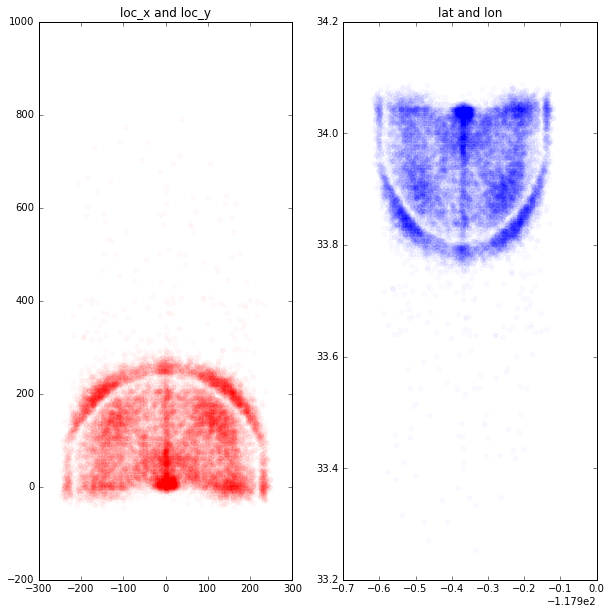

In [38]:
alpha = 0.02
plt.figure(figsize=(10,10))
#for subplots
#http://www.python-course.eu/matplotlib_multiple_figures.php
# Trying linegraph (plt.plot) instead of scatter (scatter)
# loc_x and loc_y
plt.subplot(121)
plt.scatter(nona.loc_x, nona.loc_y, color='red', alpha=alpha)
plt.title('loc_x and loc_y')

# lat and lon
plt.subplot(122)
plt.scatter(nona.lon, nona.lat, color='blue', alpha=alpha)
plt.title('lat and lon')

These plot are shaped like basket ball courts. So loc_x, loc_y, lat and lon seem to mean the position from which the ball was tossed. 
However, since the region under the net is half-circle-shaped, it would be more suitable to transform the variable into polar coodinate.
https://en.wikipedia.org/wiki/Polar_coordinate_system


In [40]:
#The Cartesian coordinates x and y can be converted to polar coordinates 
#r and ϕ with r ≥ 0 and ϕ in the interval (−π, π] by:
# r={\sqrt {x^{2}+y^{2}}  (as in the Pythagorean theorem or the Euclidean norm)
raw['dist'] = np.sqrt(raw['loc_x']**2 + raw['loc_y']**2)



In [41]:
raw['dist'].head()

0    181.859836
1    157.000000
2    168.600119
3    222.865430
4      0.000000
Name: dist, dtype: float64

In [42]:
loc_x_zero = raw['loc_x'] == 0
raw['angle'] = np.array([0]*len(raw))

In [47]:
#arctan is the slope or sin/cos
raw['angle'][~loc_x_zero] = np.arctan(raw['loc_y'][~loc_x_zero] / raw['loc_x'][~loc_x_zero])

In [48]:
#Since some of loc_x values cause an error by zero-division, we set just np.pi / 2 to the corresponding rows.
raw['angle'][loc_x_zero] = np.pi / 2 

## minutes_remaining and seconds_remaining
minutes_remaining and seconds_remaining seem to be a pair, so let's combine them together.

In [49]:
raw['remaining_time'] = raw['minutes_remaining'] * 60 + raw['seconds_remaining']

### action_type, combined_shot_type, shot_type
These represents how the player shot a ball.

In [50]:
print(nona.action_type.unique())
print(nona.combined_shot_type.unique())
print(nona.shot_type.unique())

['Jump Shot' 'Driving Dunk Shot' 'Layup Shot' 'Running Jump Shot'
 'Reverse Dunk Shot' 'Slam Dunk Shot' 'Driving Layup Shot'
 'Turnaround Jump Shot' 'Reverse Layup Shot' 'Tip Shot' 'Running Hook Shot'
 'Alley Oop Dunk Shot' 'Dunk Shot' 'Alley Oop Layup shot'
 'Running Dunk Shot' 'Driving Finger Roll Shot' 'Running Layup Shot'
 'Finger Roll Shot' 'Fadeaway Jump Shot' 'Follow Up Dunk Shot' 'Hook Shot'
 'Turnaround Hook Shot' 'Jump Hook Shot' 'Running Finger Roll Shot'
 'Jump Bank Shot' 'Turnaround Finger Roll Shot' 'Hook Bank Shot'
 'Driving Hook Shot' 'Running Tip Shot' 'Running Reverse Layup Shot'
 'Driving Finger Roll Layup Shot' 'Fadeaway Bank shot' 'Pullup Jump shot'
 'Finger Roll Layup Shot' 'Turnaround Fadeaway shot'
 'Driving Reverse Layup Shot' 'Driving Slam Dunk Shot'
 'Step Back Jump shot' 'Turnaround Bank shot' 'Reverse Slam Dunk Shot'
 'Floating Jump shot' 'Putback Slam Dunk Shot' 'Running Bank shot'
 'Driving Bank shot' 'Driving Jump shot' 'Putback Layup Shot'
 'Putback Dun

## Season
Season looks like consisting of two parts.

In [51]:
nona['season'].unique()


array(['2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06',
       '2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12',
       '2012-13', '2013-14', '2014-15', '2015-16', '1996-97', '1997-98',
       '1998-99', '1999-00'], dtype=object)

In [61]:
#Season seems to be composed of two parts: season year and season ID. 
#Here we only need season ID. Let's modify the data.

raw['season'] = nona['season'].apply(lambda x: int(x.split('-')[1]) )
raw['season'].unique()


array([ nan,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  97.,  98.,  99.,   0.])

## team_id and team_name
These contain the same one value for each. Seem useless.

In [62]:
print(nona['team_id'].unique())
print(nona['team_name'].unique())

[1610612747]
['Los Angeles Lakers']


## opponent , matchup
These are basically the same information.

In [64]:
pd.DataFrame({'matchup':nona.matchup, 'opponent':nona.opponent}).head(5)
#Only opponent is needed.

,matchup,opponent
1,LAL @ POR,POR
2,LAL @ POR,POR
3,LAL @ POR,POR
4,LAL @ POR,POR
5,LAL @ POR,POR


## Shot distance
We already defined this.

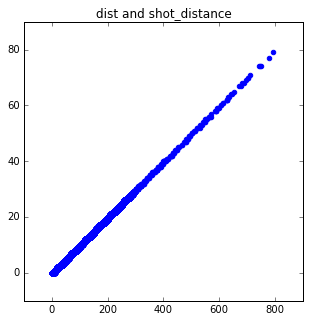

In [65]:
plt.figure(figsize=(5,5))

plt.scatter(raw.dist, raw.shot_distance, color='blue')
plt.title('dist and shot_distance')
#shot_distance is proportional to dist and this won't be necessary.

## shot_zone_area, shot_zone_basic, shot_zone_range
These sound like some regions on the court, so let's visualize it.

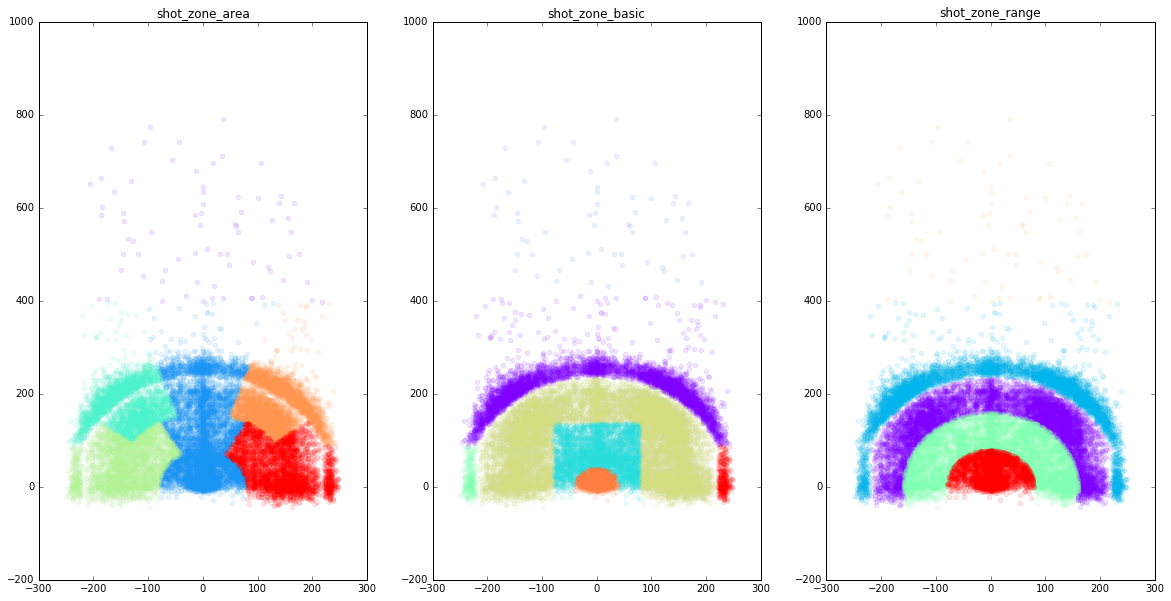

In [66]:
import matplotlib.cm as cm
plt.figure(figsize=(20,10))

def scatter_plot_by_category(feat):
    alpha = 0.1
    gs = nona.groupby(feat)
    cs = cm.rainbow(np.linspace(0, 1, len(gs)))
    for g, c in zip(gs, cs):
        plt.scatter(g[1].loc_x, g[1].loc_y, color=c, alpha=alpha)

# shot_zone_area
plt.subplot(131)
scatter_plot_by_category('shot_zone_area')
plt.title('shot_zone_area')

# shot_zone_basic
plt.subplot(132)
scatter_plot_by_category('shot_zone_basic')
plt.title('shot_zone_basic')

# shot_zone_range
plt.subplot(133)
scatter_plot_by_category('shot_zone_range')
plt.title('shot_zone_range')
#As we thought, these represent regions on the court. 
#However, these regions can be separated by dist and angle. So we don't need these.

## dropping unneeded variables
Let's drop unnecessary variables.

In [67]:
drops = ['shot_id', 'team_id', 'team_name', 'shot_zone_area', 'shot_zone_range', 'shot_zone_basic', \
         'matchup', 'lon', 'lat', 'seconds_remaining', 'minutes_remaining', \
         'shot_distance', 'loc_x', 'loc_y', 'game_event_id', 'game_id', 'game_date']
for drop in drops:
    raw = raw.drop(drop, 1)

## make dummy variables
We are going to use randomForest classifier for building our models but this doesn't accept string variables like 'action_type'. So we are going to make dummy variables for those.

In [68]:
# turn categorical variables into dummy variables
categorical_vars = ['action_type', 'combined_shot_type', 'shot_type', 'opponent', 'period', 'season']
for var in categorical_vars:
    raw = pd.concat([raw, pd.get_dummies(raw[var], prefix=var)], 1)
    raw = raw.drop(var, 1)

## separating data for training and submission
Now let's separate data.

In [69]:
df = raw[pd.notnull(raw['shot_made_flag'])]
submission = raw[pd.isnull(raw['shot_made_flag'])]
submission = submission.drop('shot_made_flag', 1)

We are separating df further into explanatory and response variables.

In [70]:
# separate df into explanatory and response variables
train = df.drop('shot_made_flag', 1)
train_y = df['shot_made_flag']

## logloss
Submissions are evaluated on the log loss. We are going to use it for evaluating our model.

In [71]:
#https://www.kaggle.com/wiki/LogarithmicLoss
#code
import scipy as sp
def logloss(act, pred):
    epsilon = 1e-15
    pred = sp.maximum(epsilon, pred)
    pred = sp.minimum(1-epsilon, pred)
    ll = sum(act*sp.log(pred) + sp.subtract(1,act)*sp.log(sp.subtract(1,pred)))
    ll = ll * -1.0/len(act)
    return ll

## Building a model
Now it's time to build a model. We use randomForest classifier and k-fold cross validation for testing our model. We are going to...
1. pick a n from n_range for the number of estimators in randomForestClassifier.
2. divide the training data into 10 pieces
3. pick 9 of them for building a model and use the remaining 1 for testing a model
4. repeat the same process for the other 9 pieces.
5. calculate score for each and take an average of them
6. pick the next n and do the process again
7. find the n which gave the best score among n_range
8. repeat the same process with the tree depth parameter.

You can change the value of np.logspace for searching optimum value in broader area.

In [72]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
import time


# find the best n_estimators for RandomForestClassifier
print('Finding best n_estimators for RandomForestClassifier...')
min_score = 100000
best_n = 0
scores_n = []
range_n = np.logspace(0,2,num=3).astype(int)
for n in range_n:
    print("the number of trees : {0}".format(n))
    t1 = time.time()
    
    rfc_score = 0.
    rfc = RandomForestClassifier(n_estimators=n)
    for train_k, test_k in KFold(len(train), n_folds=10, shuffle=True):
        rfc.fit(train.iloc[train_k], train_y.iloc[train_k])
        #rfc_score += rfc.score(train.iloc[test_k], train_y.iloc[test_k])/10
        pred = rfc.predict(train.iloc[test_k])
        rfc_score += logloss(train_y.iloc[test_k], pred) / 10
    scores_n.append(rfc_score)
    if rfc_score < min_score:
        min_score = rfc_score
        best_n = n
        
    t2 = time.time()
    print('Done processing {0} trees ({1:.3f}sec)'.format(n, t2-t1))
print(best_n, min_score)


# find best max_depth for RandomForestClassifier
print('Finding best max_depth for RandomForestClassifier...')
min_score = 100000
best_m = 0
scores_m = []
range_m = np.logspace(0,2,num=3).astype(int)
for m in range_m:
    print("the max depth : {0}".format(m))
    t1 = time.time()
    
    rfc_score = 0.
    rfc = RandomForestClassifier(max_depth=m, n_estimators=best_n)
    for train_k, test_k in KFold(len(train), n_folds=10, shuffle=True):
        rfc.fit(train.iloc[train_k], train_y.iloc[train_k])
        #rfc_score += rfc.score(train.iloc[test_k], train_y.iloc[test_k])/10
        pred = rfc.predict(train.iloc[test_k])
        rfc_score += logloss(train_y.iloc[test_k], pred) / 10
    scores_m.append(rfc_score)
    if rfc_score < min_score:
        min_score = rfc_score
        best_m = m
    
    t2 = time.time()
    print('Done processing {0} trees ({1:.3f}sec)'.format(m, t2-t1))
print(best_m, min_score)

Finding best n_estimators for RandomForestClassifier...
the number of trees : 1
Done processing 1 trees (1.122sec)
the number of trees : 10
Done processing 10 trees (5.691sec)
the number of trees : 100
Done processing 100 trees (50.843sec)
100 11.7728452286
Finding best max_depth for RandomForestClassifier...
the max depth : 1
Done processing 1 trees (4.611sec)
the max depth : 10
Done processing 10 trees (17.268sec)
the max depth : 100
Done processing 100 trees (52.754sec)
10 11.0134470921


## Visualizing parameters for randomForest
By visualizing the parameters, we can check if the chosen parameter is really the best.

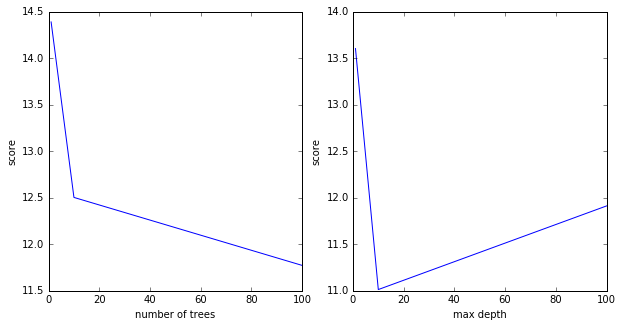

In [73]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(range_n, scores_n)
plt.ylabel('score')
plt.xlabel('number of trees')

plt.subplot(122)
plt.plot(range_m, scores_m)
plt.ylabel('score')
plt.xlabel('max depth')

## Building a final model
Let's use the parameters we just got for the final model and prediction.

In [74]:
model = RandomForestClassifier(n_estimators=best_n, max_depth=best_m)
model.fit(train, train_y)
pred = model.predict_proba(submission)

In [75]:
sub = pd.read_csv("sample_submission.csv")
sub['shot_made_flag'] = pred
sub.to_csv("real_submission.csv", index=False)

In [76]:
from xgboost.sklearn import XGBClassifier
from sklearn.cross_validation import cross_val_score

ImportError: No module named 'xgboost'